#### Import modules and prepare dataset

In [1]:
# Import package.
from package.package import *

# Import dataset.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# initializing data type as unsinged int (non-negative integer).
X_train = X_train.reshape(X_train.shape[0], -1).astype('uint8')
X_test = X_test.reshape(X_test.shape[0], -1).astype('uint8')

# X represents the hand written digits which are 28 x 28 in size.
print(f'X_train.shape: {X_train.shape}')    # -> (60,000, 784)

# Y is the actual digits they represent.
print(f'y_train.shape: {y_train.shape}')    # -> (60,000,)

print(f'X_test.shape: {X_test.shape}')    # -> (10,000, 784)
print(f'y_test.shape: {y_test.shape}')    # -> (10,000,)


X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


#### Visualize the data with TNSE

c:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rohan\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


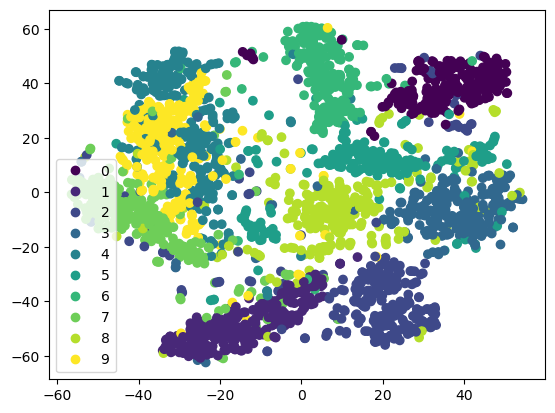

In [2]:
# Initializing data reduction algorithm
tsne = TSNE()

# Change the data accordingly to the algorithm.
X_test_trans = tsne.fit_transform(X_test[:2500])

# Scatter the data.
scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test[:2500])
plt.legend(*scatter.legend_elements())
plt.show()

# Data is formed in clusters and looks to be linearly seperable.


#### Data analysis

In [3]:
# Concatenating both train and test datasets.
data = np.concatenate((X_train, X_test))
target = np.concatenate((y_train, y_test))

# Check % of data that's 0.
percent_of_zeros = np.sum(data == 0)/data.size    # -> 80%
percent_of_non_zeros = np.sum(data != 0)/data.size    # -> 20%

# Check for null values.
check_null = np.isnan(np.sum(data))    # -> False

# Create scaler.
scaler = MinMaxScaler()

# Keep sample for comparison.
sample = X_train[0]

# Scale the data.
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Compare the two samples and their values
print('Before data transformation: {}'.format(sample[np.where(sample != 0)][:5]))
print('After data transformation:  {}'.format(X_train[np.where(X_train != 0)][:5]))

# Change to categorical data.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Change data to image data.
X_train = X_train.reshape((60000, 28, 28, 1)).astype('float32')
X_test = X_test.reshape((10000, 28, 28, 1)).astype('float32')


Before data transformation: [  3  18  18  18 126]
After data transformation:  [0.01176471 0.07058824 0.07058824 0.07058824 0.49411765]


#### Apply linear model to the data

In [4]:
# Creating simple linear model to learn more about data.
perceptron = Perceptron(max_iter=99999999)    # Perceptron only works when data is linear.

# NOTE: Perceptron is a neural network with only one hidden-layer.

# Create function that reforms the data for the algorithm.
def reform_sklearn(*arrays):
    
    old_arrays = arrays
    reformed_arrays = []
    print('Reforming arrays...')

    for array in arrays:

        # Array is a data variable.
        if array.ndim != 2:
            reformed_arrays.append(array.reshape(len(array), -1))
    
        # Array is a target variable
        else:
            reformed_arrays.append(np.array([np.argmax(sample) for sample in array]))
    
    print('Old array shapes: {}'.format([array.shape for array in old_arrays]))
    print('New array shapes: {}\n'.format([array.shape for array in reformed_arrays]))
    return reformed_arrays

per_X_train, per_X_test = reform_sklearn(X_train, X_test)
per_y_train, per_y_test = reform_sklearn(y_train, y_test)

# NOTE: perceptrons are not good for image processing,
#       meaning the data must be 1D, not 2D.

start_time = time()

perceptron.fit(per_X_train, per_y_train)

print(f'Perceptron train score: {perceptron.score(per_X_train, per_y_train)}')
print(f'Perceptron test score: {perceptron.score(per_X_test, per_y_test)}')
print(f'Iterations used: {perceptron.n_iter_}')
print(f'Elapsed: {(time() - start_time)/60:.2f} min.')

# NOTE: Based on the results on the perceptron and that the model used little iterations/epochs
#       to fit the data, we can assume the data is linearly seperable.


Reforming arrays...
Old array shapes: [(60000, 28, 28, 1), (10000, 28, 28, 1)]
New array shapes: [(60000, 784), (10000, 784)]

Reforming arrays...
Old array shapes: [(60000, 10), (10000, 10)]
New array shapes: [(60000,), (10000,)]

Perceptron train score: 0.9024666666666666
Perceptron test score: 0.8951
Iterations used: 24
Elapsed: 0.27 min.


#### Apply neural net model to the data

CNN Train Score: 99.01
CNN Test Score: 98.18
Elapsed: 1.52 min.


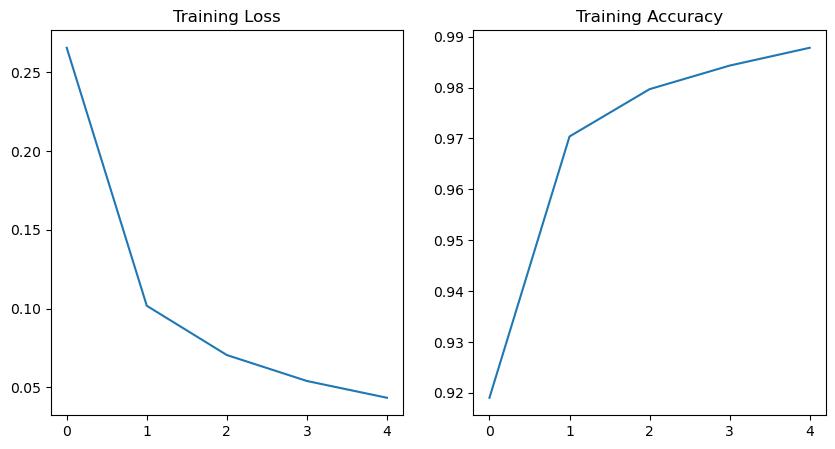

In [5]:
# Create convolutional neural network.

# NOTE: Convolutional neural networks (CNNs) are used as a machine learning model for processing images.
#       This algorithm goes thorugh different steps of processing the images in different ways,
#       eventually finding a pattern in the data.

# Begin cited code:
# https://rb.gy/yykaxm
def model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # Compile model.
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# End cited code.

# NOTE: Sequential() models allow you to make models layer-by-layer and is much simpler compared to Input() models.
#       Conv2D() is an input layer for converting an image in to a matrix.
#       MaxPooling2D() is another input layer.
#       Flatten() converts multi-dimensional data into a single vector to be processed. Ex: 28 x 28 -> 784
#       Dense() is the main hidden layer.
#       SGD() is the stochastic gradient descent optimization function to update weights.
#       relu activation function is a nonlinear function that is good for learning complex functions.
#       softmax activation function is used to quantify the output in classification examples.

# Create timer.
start_time = time()

model = model()
results = model.fit(X_train, y_train, epochs=5, batch_size=128).history

# Clear the output.
clear_output()

# NOTE: batch_size param means that the model will be tested on 64 samples at a time.
#       This save a ton of RAM during the training process.

print(train_score := 'CNN Train Score: {:.2f}'.format(model.evaluate(X_train, y_train, verbose=False)[1]*100))
print(test_score := 'CNN Test Score: {:.2f}'.format(model.evaluate(X_test, y_test, verbose=False)[1]*100))
print(elapsed := f'Elapsed: {(time() - start_time)/60:.2f} min.')

# Notify when done.
notification.notify(
    title='Neural Network Training Results',
    message=f'{train_score}\n{test_score}\n{elapsed}',
    app_icon='python_icon.ico'
)

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(5), results['loss'])
ax_1.set_title('Training Loss');

ax_2.plot(range(5), results['accuracy'])
ax_2.set_title('Training Accuracy');


#### Test the model with visualizations

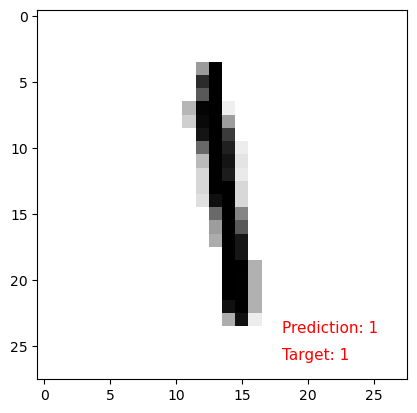

In [6]:
# Ask user for specific number to test model.
def pick_num(num):
    try:
        number = int(num)
    except ValueError:
        raise ValueError('Please choose a number')
    else:
        return number

# Call function
number = pick_num(input('Choose a number to test the model on -> '))

# Revert the target data from to_categorical()
og_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])

# Get the random index for the sample and the sample target.
index = choice(np.where(og_y_test == number)[0])
sample = X_test[index].reshape(1, 28, 28, 1)
sample_target = og_y_test[index]

prediction = np.argmax(model.predict(sample))

sample_img = sample.reshape(28, 28)

plt.imshow(sample_img, cmap='binary')
plt.text(18, 24, f'Prediction: {prediction}', fontsize=11, color='red');
plt.text(18, 26, f'Target: {sample_target}', fontsize=11, color='red');


#### List of dependencies
* https://www.tensorflow.org/
* https://bit.ly/3pWvxTz
* https://bit.ly/3stGnlr
* https://bit.ly/2NGYyFG
* https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
* https://bit.ly/2NJ1kdp
* https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD
* https://bit.ly/2O6ySC1
* https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist
* https://ipython.readthedocs.io/en/stable/interactive/plotting.html
* https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
* https://numpy.org/
* https://docs.python.org/3/library/time.html
* https://github.com/kivy/plyer/blob/master/plyer/facades/notification.py
* https://docs.python.org/3/library/random.html
* https://bit.ly/3svyQml

## Additional Tests (This is all for particle physics projects)

#### Create Model (only tested on 3500 samples)

Epoch 1/500
42/42 [==============================] - 1s 19ms/step - loss: 2.0421 - accuracy: 0.4907
Epoch 2/500
42/42 [==============================] - 1s 20ms/step - loss: 1.9227 - accuracy: 0.5547
Epoch 3/500
42/42 [==============================] - 1s 24ms/step - loss: 2.1195 - accuracy: 0.5467
Epoch 4/500
42/42 [==============================] - 1s 20ms/step - loss: 1.3004 - accuracy: 0.7703
Epoch 5/500
42/42 [==============================] - 1s 22ms/step - loss: 1.2494 - accuracy: 0.7931
Epoch 6/500
42/42 [==============================] - 1s 20ms/step - loss: 0.8469 - accuracy: 0.9013
Epoch 7/500
42/42 [==============================] - 1s 21ms/step - loss: 0.7173 - accuracy: 0.9215
Epoch 8/500
42/42 [==============================] - 1s 25ms/step - loss: 0.6375 - accuracy: 0.9333
Epoch 9/500
42/42 [==============================] - 1s 27ms/step - loss: 0.5706 - accuracy: 0.9410
Epoch 10/500
42/42 [==============================] - 1s 27ms/step - loss: 0.5245 - accuracy: 0.9432

TypeError: list indices must be integers or slices, not str

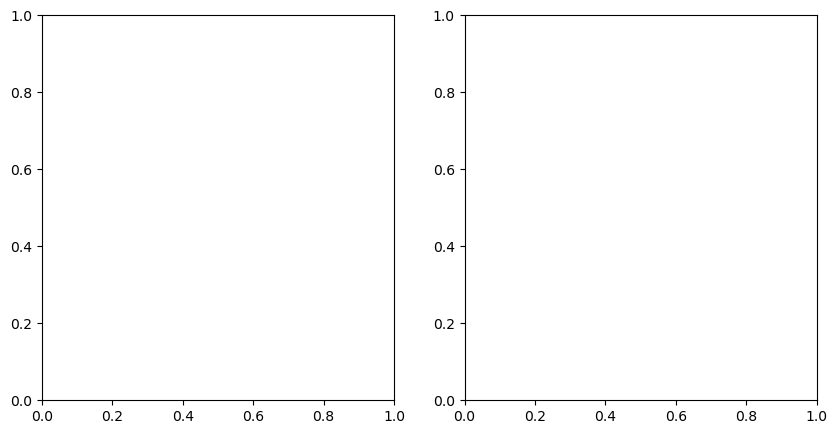

In [12]:
X_train_shortened, X_test_shortened = (X_train[:2625], X_test[:875])
y_train_shortened, y_test_shortened = (y_train[:2625], y_test[:875])

def same_model():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(19, activation='relu', kernel_regularizer='l2'))    # same inner layer config found in particle physics project 
    model.add(Dense(19, activation='relu', kernel_regularizer='l2'))
    # model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
	
    # Compile model.
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_shortened = same_model()
results_shortened = model_shortened.fit(X_train_shortened, y_train_shortened, epochs=500, batch_size=64).history

# Clear the output.
# clear_output()

print(train_score_shortened := 'CNN Train Score: {:.2f}'.format(model_shortened.evaluate(X_train_shortened, y_train_shortened, verbose=False)[1]*100))
print(test_score_shortened := 'CNN Test Score: {:.2f}'.format(model_shortened.evaluate(X_test_shortened, y_test_shortened, verbose=False)[1]*100))

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(5), results['loss'])
ax_1.set_title('Training Loss');

ax_2.plot(range(5), results['accuracy'])
ax_2.set_title('Training Accuracy');


In [8]:
# just to show that the datasets are not imbalanced...

y_train_new_labels = []

for label in list(y_train[:3500]):
    y_train_new_labels.append(list(label).index(1))

y_train_new_labels = np.array(y_train_new_labels)

unique_values, counts = np.unique(y_train_new_labels, return_counts=True)
print(dict(zip(unique_values, counts)))


{0: 332, 1: 391, 2: 347, 3: 346, 4: 386, 5: 310, 6: 350, 7: 379, 8: 317, 9: 342}


#### Individual Digit Test

In [9]:
def individual_digit_test(model):
    for i in range(9):
        int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
        number_indexes = np.where(int_y_test == i)    # gives indexes for all numbers 0-9

        X_test_modified = X_test[number_indexes]
        y_test_modified = y_test[number_indexes]

        print(f'{i} accuracy: {model.evaluate(X_test_modified, y_test_modified, verbose=False)[1]*100:.1f}%')

    return number_indexes

individual_digit_test(model_shortened) # Check the difference between these reusts and the particle physics stuff


0 accuracy: 96.5%
1 accuracy: 99.3%
2 accuracy: 95.6%
3 accuracy: 93.9%
4 accuracy: 94.1%
5 accuracy: 96.5%
6 accuracy: 95.2%
7 accuracy: 91.5%
8 accuracy: 91.7%


(array([  61,   84,  110,  128,  134,  146,  177,  179,  181,  184,  226,
         232,  233,  242,  257,  260,  266,  268,  277,  290,  299,  338,
         344,  355,  373,  374,  391,  401,  403,  429,  431,  435,  436,
         458,  465,  466,  470,  474,  486,  495,  520,  527,  538,  542,
         543,  553,  563,  572,  580,  582,  591,  596,  601,  603,  606,
         621,  631,  641,  655,  664,  685,  691,  693,  709,  714,  718,
         761,  781,  787,  793,  800,  805,  806,  839,  844,  864,  872,
         876,  877,  878,  879,  899,  914,  915,  936,  947,  961,  983,
         998, 1007, 1018, 1026, 1029, 1033, 1052, 1068, 1074, 1093, 1101,
        1118, 1120, 1124, 1125, 1149, 1170, 1185, 1198, 1200, 1202, 1219,
        1225, 1229, 1234, 1248, 1249, 1259, 1267, 1268, 1286, 1287, 1312,
        1319, 1320, 1324, 1325, 1353, 1364, 1371, 1389, 1394, 1398, 1415,
        1425, 1433, 1441, 1443, 1464, 1470, 1474, 1499, 1502, 1523, 1524,
        1530, 1541, 1556, 1560, 1562, 

#### Create Separate Datasets (in preparation for test on next cell)

In [10]:
data_50_samples, target_50_samples = (X_train_shortened[:50], y_train_shortened[:50])
data_100_samples, target_100_samples = (X_train_shortened[:100], y_train_shortened[:100])
data_150_samples, target_150_samples = (X_train_shortened[:150], y_train_shortened[:150])
data_200_samples, target_200_samples = (X_train_shortened[:200], y_train_shortened[:200])
data_250_samples, target_250_samples = (X_train_shortened[:250], y_train_shortened[:250])
data_300_samples, target_300_samples = (X_train_shortened[:300], y_train_shortened[:300])
data_350_samples, target_350_samples = (X_train_shortened[:350], y_train_shortened[:350])
data_400_samples, target_400_samples = (X_train_shortened[:400], y_train_shortened[:400])
data_450_samples, target_450_samples = (X_train_shortened[:450], y_train_shortened[:450])
data_500_samples, target_500_samples = (X_train_shortened[:500], y_train_shortened[:500])
data_550_samples, target_550_samples = (X_train_shortened[:550], y_train_shortened[:550])
data_600_samples, target_600_samples = (X_train_shortened[:600], y_train_shortened[:600])
data_650_samples, target_650_samples = (X_train_shortened[:650], y_train_shortened[:650])
data_700_samples, target_700_samples = (X_train_shortened[:700], y_train_shortened[:700])

#### Graph relationship between sample size and accuracy

In [11]:
info_x_samples = [
    (data_50_samples, target_50_samples), 
    (data_100_samples, target_100_samples),
    (data_150_samples, target_150_samples), 
    (data_200_samples, target_200_samples), 
    (data_250_samples, target_250_samples), 
    (data_300_samples, target_300_samples), 
    (data_350_samples, target_350_samples), 
    (data_400_samples, target_400_samples), 
    (data_450_samples, target_450_samples),
    (data_500_samples, target_500_samples), 
    (data_550_samples, target_550_samples), 
    (data_600_samples, target_600_samples), 
    (data_650_samples, target_650_samples), 
    (data_700_samples, target_700_samples)
]

sample_numbers = (list(range(50, 701, 50)))
results = []

def samples_test():
    results.append([])    # One of these arrays represents a new trial... check https://github.com/rohannakra/AI-Predicts-Particle-Collisions/blob/master/R%20Data%20Analysis/data/samples_test_data.csv for example

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]

        temp_tf_model = same_model()

        temp_tf_model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)

        initial_accuracy = temp_tf_model.evaluate(X_train_shortened, y_train_shortened, verbose=False)[1]    # The result is the accuracy on the main dataset based on how many samples given to train on.

        print(f'\nTrain accuracy: {initial_accuracy*100:.1f}% ({sample_number} samples)')

        results[-1].append(initial_accuracy)    # Updating trial based on accuracy from a samples test.

for i in range(50):
    samples_test()



Train accuracy: 21.3% (50 samples)

Train accuracy: 14.1% (100 samples)

Train accuracy: 41.8% (150 samples)

Train accuracy: 45.9% (200 samples)

Train accuracy: 37.4% (250 samples)

Train accuracy: 56.1% (300 samples)

Train accuracy: 42.9% (350 samples)

Train accuracy: 31.2% (400 samples)

Train accuracy: 59.6% (450 samples)

Train accuracy: 71.3% (500 samples)

Train accuracy: 64.3% (550 samples)

Train accuracy: 65.7% (600 samples)

Train accuracy: 74.5% (650 samples)

Train accuracy: 73.8% (700 samples)

Train accuracy: 20.9% (50 samples)

Train accuracy: 21.9% (100 samples)

Train accuracy: 24.6% (150 samples)

Train accuracy: 31.5% (200 samples)

Train accuracy: 45.9% (250 samples)

Train accuracy: 51.7% (300 samples)

Train accuracy: 39.7% (350 samples)

Train accuracy: 61.5% (400 samples)

Train accuracy: 61.8% (450 samples)

Train accuracy: 67.5% (500 samples)

Train accuracy: 62.0% (550 samples)

Train accuracy: 71.2% (600 samples)


KeyboardInterrupt: 

#### Prepare results from tests for R data analysis

In [29]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/test_results/samples_test_results.csv')

#### Samples test (with 175 samples as test set)

In [ ]:
# In this test, we use same formual for adding the results, but instead of appending accuracy on X_train_shortened, we append accuracy on X_train_shortened[:175]

sample_numbers = (list(range(50, 701, 50)))
results = []
test_data_175 = X_test_shortened[:175]
test_labels_175 = y_test_shortened[:175]

def samples_test_new():
    results.append([])

    for sample_number, i in zip(sample_numbers, range(14)):
        data_x_samples = info_x_samples[i][0]
        target_x_samples = info_x_samples[i][1]

        temp_tf_model = same_model()

        temp_tf_model.fit(data_x_samples, target_x_samples, epochs=3, batch_size=64, verbose=False)

        initial_accuracy = temp_tf_model.evaluate(X_train_shortened, y_train_shortened, verbose=False)[1]    # The result is the accuracy on the main dataset based on how many samples given to train on.
        test_accuracy = temp_tf_model.evaluate(test_data_175, test_labels_175, verbose=False)[1]    # NOTE: This is the difference from this test & the previous.

        print(f'{sample_number} samples train: {initial_accuracy*100:.1f}%; test: {test_accuracy}')

        results[-1].append(test_accuracy)    # Updating trial based on accuracy from a samples test.

for i in range(50):
    samples_test()


c:\Users\rohan\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Train accuracy: 17.0% (50 samples)

Train accuracy: 30.3% (100 samples)

Train accuracy: 33.1% (150 samples)

Train accuracy: 30.6% (200 samples)

Train accuracy: 47.1% (250 samples)

Train accuracy: 55.7% (300 samples)

Train accuracy: 66.6% (350 samples)

Train accuracy: 63.2% (400 samples)

Train accuracy: 27.4% (450 samples)

Train accuracy: 73.4% (500 samples)

Train accuracy: 73.5% (550 samples)

Train accuracy: 71.7% (600 samples)

Train accuracy: 71.8% (650 samples)

Train accuracy: 75.6% (700 samples)

Train accuracy: 11.2% (50 samples)

Train accuracy: 32.6% (100 samples)

Train accuracy: 34.0% (150 samples)

Train accuracy: 30.0% (200 samples)

Train accuracy: 34.9% (250 samples)

Train accuracy: 43.8% (300 samples)

Train accuracy: 36.7% (350 samples)

Train accuracy: 68.1% (400 samples)

Train accuracy: 40.9% (450 samples)

Train accuracy: 67.5% (500 samples)

Train accuracy: 69.2% (550 samples)

Train accuracy: 71.9% (600 samples)

Train accuracy: 75.6% (650 samples)

Tr

#### Prepare CSV for R Data Analysis

In [31]:
results = np.array(results)
df = pd.DataFrame(results, columns=[f'{num} samples' for num in range(50, 701, 50)])
df.to_csv('R Data Analysis/test_results/samples_test_175_results.csv')